In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import torchvision.models as models
from torchsummary import summary
from matplotlib import pyplot as plt
from collections import namedtuple
import time
from tqdm.notebook import tqdm as tqdm

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Downloading CIFAR10 dataset
dataset = datasets.CIFAR10(root='data', train= True, transform=ToTensor(), download= True)
test_dataset = datasets.CIFAR10(root='data', train= False, transform=ToTensor(), download= True)

100%|██████████| 170498071/170498071 [00:05<00:00, 29095208.44it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
print(len(dataset))
print(len(test_dataset))
print(type(dataset))

50000
10000
<class 'torchvision.datasets.cifar.CIFAR10'>


In [ ]:
print(type(dataset.data))
print(dataset.data.shape)
print(test_dataset.data.shape)

<class 'numpy.ndarray'>
(50000, 32, 32, 3)
(10000, 32, 32, 3)


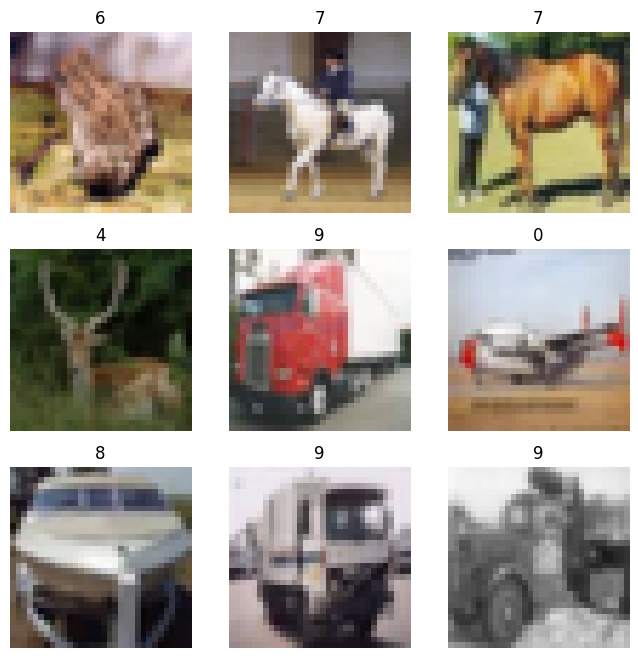

In [ ]:
# Visualizing the Dataset
figure = plt.figure(figsize=(8,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows,cols,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img.permute(1,2,0))
plt.show()

In [ ]:
# split dataset to train_dataset and valid_dataset
num_train = int(len(dataset)*0.8)
num_valid = len(dataset)-num_train
train_dataset, valid_dataset = data.random_split(dataset, [num_train, num_valid])
print(f'The number of training dataset: {len(train_dataset)}')
print(f'The number of valid dataset: {len(valid_dataset)}')
print(f'The number of test dataset: {len(test_dataset)}')

The number of training dataset: 40000
The number of valid dataset: 10000
The number of test dataset: 10000


In [ ]:
BATCH_SIZE = 128
train_iterator = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_iterator = data.DataLoader(valid_dataset, batch_size=BATCH_SIZE)
dataloader_dict={'train':train_iterator, 'val':valid_iterator}
test_iterator = data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
# Some hyperparameter r
r=4

In [ ]:
# Define basicblock
class basicblock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual=nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
            )
        self.adapavgpool=nn.AdaptiveAvgPool2d((1,1))
        self.seblock=nn.Sequential(
            nn.Linear(out_channels, out_channels//r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(out_channels//r, out_channels, bias=False),
            nn.Sigmoid()
        )
        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU(inplace=True)
        if in_channels != out_channels :
            self.shortcut.add_module('conv',
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride)
                )
            self.shortcut.add_module('bn', nn.BatchNorm2d(out_channels))


    def forward(self,x):
        h=self.shortcut(x)
        x=self.bottleneck(x)
        y=self.adapavgpool(x)
        y=y.view((y.shape[0],-1))
        y=self.seblock(y)
        y=y.view((x.shape[0],-1,1,1))
        x=x*y+h
        x=self.relu(x)
        return x

In [ ]:
# Define a bottelneck
class bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.bottleneck=nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels//4, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels//4),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels//4, out_channels=out_channels//4, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels//4),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels//4, out_channels=out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
            )
        self.adapavgpool=nn.AdaptiveAvgPool2d((1,1))
        self.seblock=nn.Sequential(
            nn.Linear(out_channels, out_channels//r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(out_channels//r, out_channels, bias=False),
            nn.Sigmoid()
        )
        self.shortcut=nn.Sequential()
        if in_channels!=out_channels:
                self.shortcut.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride))
                self.shortcut.add_module('bn', nn.BatchNorm2d(out_channels))
        self.relu=nn.ReLU(inplace=True)

    def forward(self, x):
        h=self.shortcut(x)
        x=self.bottleneck(x)
        y=self.adapavgpool(x)
        y=y.view((y.shape[0],-1))
        y=self.seblock(y)
        y=y.view((x.shape[0],-1,1,1))
        x=x*y+h
        x=self.relu(x)
        return x


In [ ]:
# Define ResNet model
class SENet(nn.Module):
    def __init__(self, config, output_dim,in_channels=3):
        super().__init__()
        block, n_blocks, channels = config
        self.channels = channels[0]
        self.cv = nn.Conv2d(in_channels=in_channels, out_channels=self.channels , kernel_size=7, stride=2, padding=3)
        self.bn = nn.BatchNorm2d(self.channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layers1 = self.get_layers(block, n_blocks[0], channels[0], channels[1])
        self.layers2 = self.get_layers(block, n_blocks[1], channels[1], channels[2])
        self.layers3 = self.get_layers(block, n_blocks[2], channels[2], channels[3])
        self.layers4 = self.get_layers(block, n_blocks[3], channels[3], channels[4])
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(channels[-1], output_dim)

    def get_layers(self, block, n_blocks, in_channels, out_channels):
        layers=[]
        if in_channels*2 == out_channels:
            stride=2
        else :
            stride=1
        layers.append(block(in_channels, out_channels, stride))
        for i in range(1, n_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)


    def forward(self, x):
        x=self.cv(x)
        x=self.bn(x)
        x=self.relu(x)
        x=self.maxpool(x)
        x=self.layers1(x)
        x=self.layers2(x)
        x=self.layers3(x)
        x=self.layers4(x)
        x=self.avgpool(x)
        h=x.view(x.shape[0],-1)
        x=self.fc(h)
        return x

In [ ]:
# Define the ResNet config
SENetConfig = namedtuple('SENetConfig', ['block', 'n_blocks', 'channels'])

In [ ]:
SENet18_config = SENetConfig(block=basicblock,
                               n_blocks=[2, 2, 2, 2],
                               channels=[64, 64, 128, 256, 512])
SENet34_config = SENetConfig(block=basicblock,
                               n_blocks=[3, 4, 6, 3],
                               channels=[64, 64, 128, 256, 512])
SENet50_config = SENetConfig(block=bottleneck,
                               n_blocks=[3, 4, 6, 3],
                               channels=[64, 256, 512, 1024, 2048])
SENet101_config = SENetConfig(block=bottleneck,
                                n_blocks=[3,4,23,3],
                                channels=[64, 256, 512, 1024, 2048])
SENet152_config = SENetConfig(block=bottleneck,
                                n_blocks=[3, 8, 36, 3],
                                channels=[64, 256, 512, 1024, 2048])

In [ ]:
#Make an object
SENet50 = SENet(SENet50_config, output_dim=10)
print(SENet50)
# origin(-1,1,28,28)
# cv(-1,16,14,14)
# bn(-1,16,14,14)
# max(-1,16,6,6)
# layers1 cv1(-1,16,7,7)
# layers1 bn1(-1,16,7,7)
# layers1 cv2(-1.16,8,8)
# layers1 bn2 (-1,16,8,8)


SENet(
  (cv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers1): Sequential(
    (0): bottleneck(
      (bottleneck): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (adapavgpool): AdaptiveAvgPool2d(outp

In [ ]:
# Define optimizer and loss functions
optimizer = optim.Adam(SENet50.parameters())
criterion = nn.CrossEntropyLoss()

SENet50 = SENet50.to(device)
criterion = criterion.to(device)

In [ ]:
summary(SENet50, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 256, 8, 8]          16,640
       BatchNorm2d-6            [-1, 256, 8, 8]             512
            Conv2d-7             [-1, 64, 8, 8]           4,096
       BatchNorm2d-8             [-1, 64, 8, 8]             128
              ReLU-9             [-1, 64, 8, 8]               0
           Conv2d-10             [-1, 64, 8, 8]          36,864
      BatchNorm2d-11             [-1, 64, 8, 8]             128
             ReLU-12             [-1, 64, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [ ]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch, early_stopping_num):
    since = time.time()
    best_val_loss = float('inf')
    tr_losses=[]
    tr_accs=[]
    val_losses=[]
    val_accs=[]
    i=0

    for epoch in range(num_epoch):
        if i==early_stopping_num:
            break
        print('Epoch {}/{}'.format(epoch+1, num_epoch))
        print('-'*30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else :
                model.eval()

            epoch_loss=0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # _ = values, preds = indices
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    # loss.item() makes a tensor of loss as a scalar
                    # size of the inputs of the 0-dim(32?)
                    epoch_loss +=loss.item() * inputs.size(0)
                    epoch_corrects +=torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            if phase=='train':
                tr_losses.append(epoch_loss)
                tr_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())
                if best_val_loss>epoch_loss:
                    best_val_loss = epoch_loss
                    i=0
                else :
                    i+=1


            print('{} Loss: {:.4f} Acc:{:.4f}'.format(phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    return tr_losses, tr_accs, val_losses, val_accs

In [ ]:
EPOCHS=100
tr_losses, tr_accs, val_losses, val_accs = train_model(SENet50, dataloader_dict, criterion, optimizer, EPOCHS, 10)

Epoch 1/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 1.6327 Acc:0.4338


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.4546 Acc:0.4788
Epoch 2/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 1.2493 Acc:0.5614


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.3744 Acc:0.5373
Epoch 3/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.9802 Acc:0.6556


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.0970 Acc:0.6227
Epoch 4/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.8309 Acc:0.7098


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.5357 Acc:0.5085
Epoch 5/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.6959 Acc:0.7552


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.0339 Acc:0.6486
Epoch 6/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.5900 Acc:0.7932


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.8754 Acc:0.6998
Epoch 7/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.4967 Acc:0.8266


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.0715 Acc:0.6729
Epoch 8/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.4150 Acc:0.8566


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.9877 Acc:0.7061
Epoch 9/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.3698 Acc:0.8729


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.0309 Acc:0.7021
Epoch 10/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.3076 Acc:0.8946


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.0419 Acc:0.7054
Epoch 11/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.2392 Acc:0.9187


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.0359 Acc:0.7210
Epoch 12/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.2153 Acc:0.9258


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.1710 Acc:0.6837
Epoch 13/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.1748 Acc:0.9409


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.1022 Acc:0.7227
Epoch 14/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.1641 Acc:0.9438


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.0765 Acc:0.7276
Epoch 15/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.1407 Acc:0.9514


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.2694 Acc:0.7121
Epoch 16/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.1239 Acc:0.9582


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.3983 Acc:0.6761
Training complete in 8m 21s


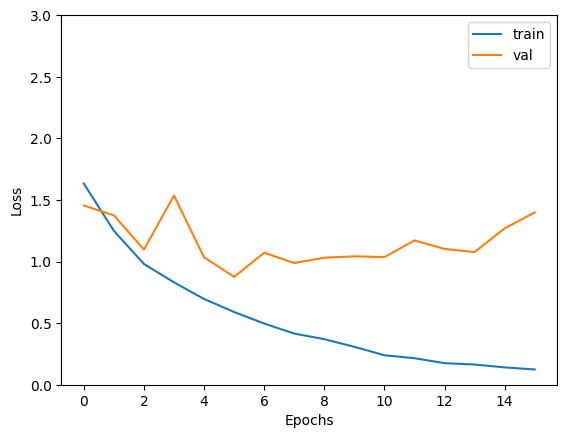

In [ ]:
plt.plot(tr_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0,3])
plt.legend(['train', 'val'])
plt.show()

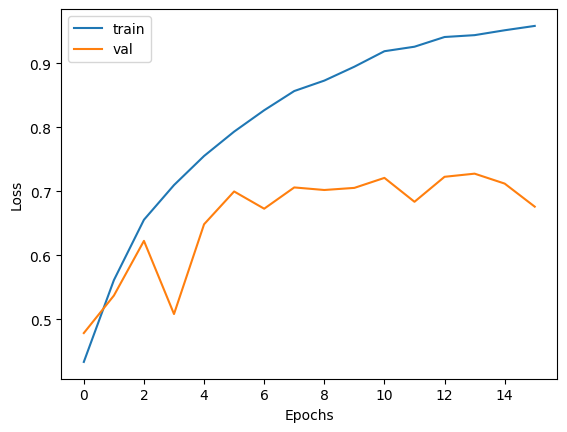

In [ ]:
plt.plot(tr_accs)
plt.plot(val_accs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
def test_model(model, test_iterator):
    since = time.time()
    model.eval()
    corrects = 0
    for inputs, labels in tqdm(test_iterator):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        # _ = values, preds = indices
        _, preds = torch.max(outputs, 1)
        corrects +=torch.sum(preds == labels.data)
    acc = corrects.double() / len(test_iterator.dataset)
    acc = acc.item()
    print('Accuracy of the test is {}%'.format(acc*100))
    time_elapsed = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))

In [ ]:
test_model(SENet50, test_iterator)

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the test is 67.89%
Test complete in 0m 3s
